In [17]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import qutip as qt
import scipy as sp
%matplotlib ipympl

plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.6f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.3e}'.format})

In [18]:
GHz=1e9

In [19]:
def premade_coupled_resonators(Δ):
    if Δ == 0:
        C   = sq.Capacitor(1, 'fF')
        L   = sq.Inductor(1, 'nH')
        elements = {(0, 1): [L, C],
                    (0, 2): [L, C], }
        return sq.Circuit(elements)

    else:
        C = sq.Capacitor(1, 'fF')
        L = sq.Inductor(1, 'nH')
        L_Δ = sq.Inductor(Δ, 'nH')
        elements = {(0, 1): [L, C],
                    (0, 2): [L, C],
                    (1, 2): [L_Δ], }
        return sq.Circuit(elements)

def premade_single_resonator(Δ):
    if Δ == 0:
        C   = sq.Capacitor(1, 'fF')
        L   = sq.Inductor(1,  'nH')
        elements = {(0, 1): [L, C],}
        return sq.Circuit(elements)

    else:
        C   = sq.Capacitor(1, 'fF')
        L   = sq.Inductor(1/(1+1/Δ), 'nH')
        elements = {(0, 1): [L, C],}
        return sq.Circuit(elements)



In [138]:
n_eig = 3
trunc_num = 10
Δ=0.1

coupled_res     = premade_coupled_resonators    (Δ=Δ)
res             = premade_single_resonator      (Δ=Δ)

uncoupled_res   = premade_coupled_resonators    (Δ=0)
res_0           = premade_single_resonator      (Δ=0)

coupled_res     .set_trunc_nums([trunc_num, trunc_num])
uncoupled_res   .set_trunc_nums([trunc_num, trunc_num])
res             .set_trunc_nums([trunc_num])
res_0           .set_trunc_nums([trunc_num])

_ = coupled_res     .diag(n_eig)
_ = uncoupled_res   .diag(n_eig)
_ = res             .diag(n_eig)
_ = res_0           .diag(n_eig)


In [139]:
Q = res.charge_op(0)
Φ = res.flux_op(0)

Q_0 = res_0.charge_op(0)
Φ_0 = res_0.flux_op(0)


In [140]:
H_res_0 = 1/2 * Q_0**2/1e-15 + 1/2 * Φ_0**2/1e-9
# H_res_0 = 1/2 * Q_0**2 + 1/2 * Φ_0**2
H_res   = 1/2 * Q**2/1e-15 + 1/2 * (1+1/Δ) * Φ**2/1e-9
# H_res   = 1/2 * Q**2+ 1/2 * (1+1/Δ) * Φ**2

# H_res_0 = res_0.hamiltonian()
# H_res   = res.hamiltonian()

I = qt.identity(H_res.shape[0])

H_unc_res = qt.tensor(H_res_0,I) + qt.tensor(I,H_res_0)
H_coup_res = qt.tensor(H_res,I) + qt.tensor(I,H_res) + (1/Δ/1e-9) * qt.tensor(Φ,Φ)
# H_coup_res = qt.tensor(H_res,I) + qt.tensor(I,H_res) + (1/Δ) * qt.tensor(Φ,Φ)


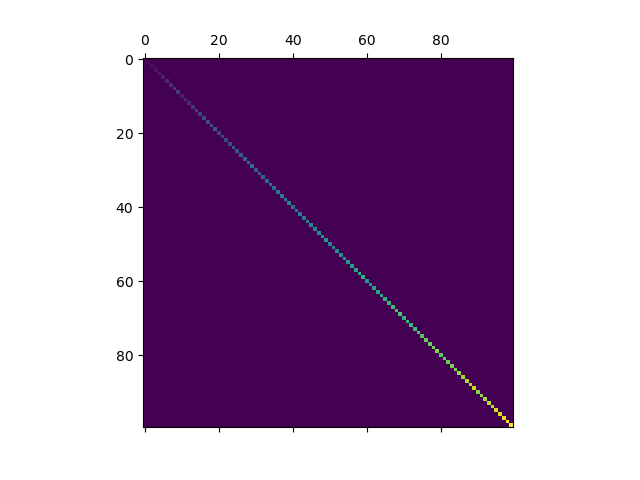

In [141]:
fig, ax = plt.subplots()
ax.matshow(np.abs(coupled_res.hamiltonian().__array__()))
fig.show()

In [142]:
_ = uncoupled_res   .diag(n_eig, solver = 'numpy')
_ = coupled_res     .diag(n_eig, solver = 'numpy')
# H_eff_full = sq_ext.H_eff_p1(uncoupled_res,coupled_res )
H_eff_full = sq_ext.H_eff_p1_hamil(uncoupled_res.hamiltonian(), coupled_res.hamiltonian(), n_eig, solver='numpy' )
# H_eff_full -= H_eff_full[0,0]*np.eye(n_eig)

H_eff_frc = sq_ext.H_eff_p1_hamil(H_unc_res, H_coup_res, n_eig, solver='numpy', remove_ground=True)
# H_eff_frc -= H_eff_frc[0,0]*np.eye(n_eig)

print(np.round(H_eff_full,8))
print('\n')
print(np.round(H_eff_frc, 8))
# print(np.round(np.abs(H_eff_full)-np.abs(H_eff_frc),4))

[[0.000000 0.000000 0.000000]
 [0.000000 159.154943 0.000000]
 [0.000000 0.000000 729.339574]]


[[0.000000 -0.000000 -0.000000]
 [-0.000000 527.857230 239.935104]
 [-0.000000 239.935104 527.857230]]


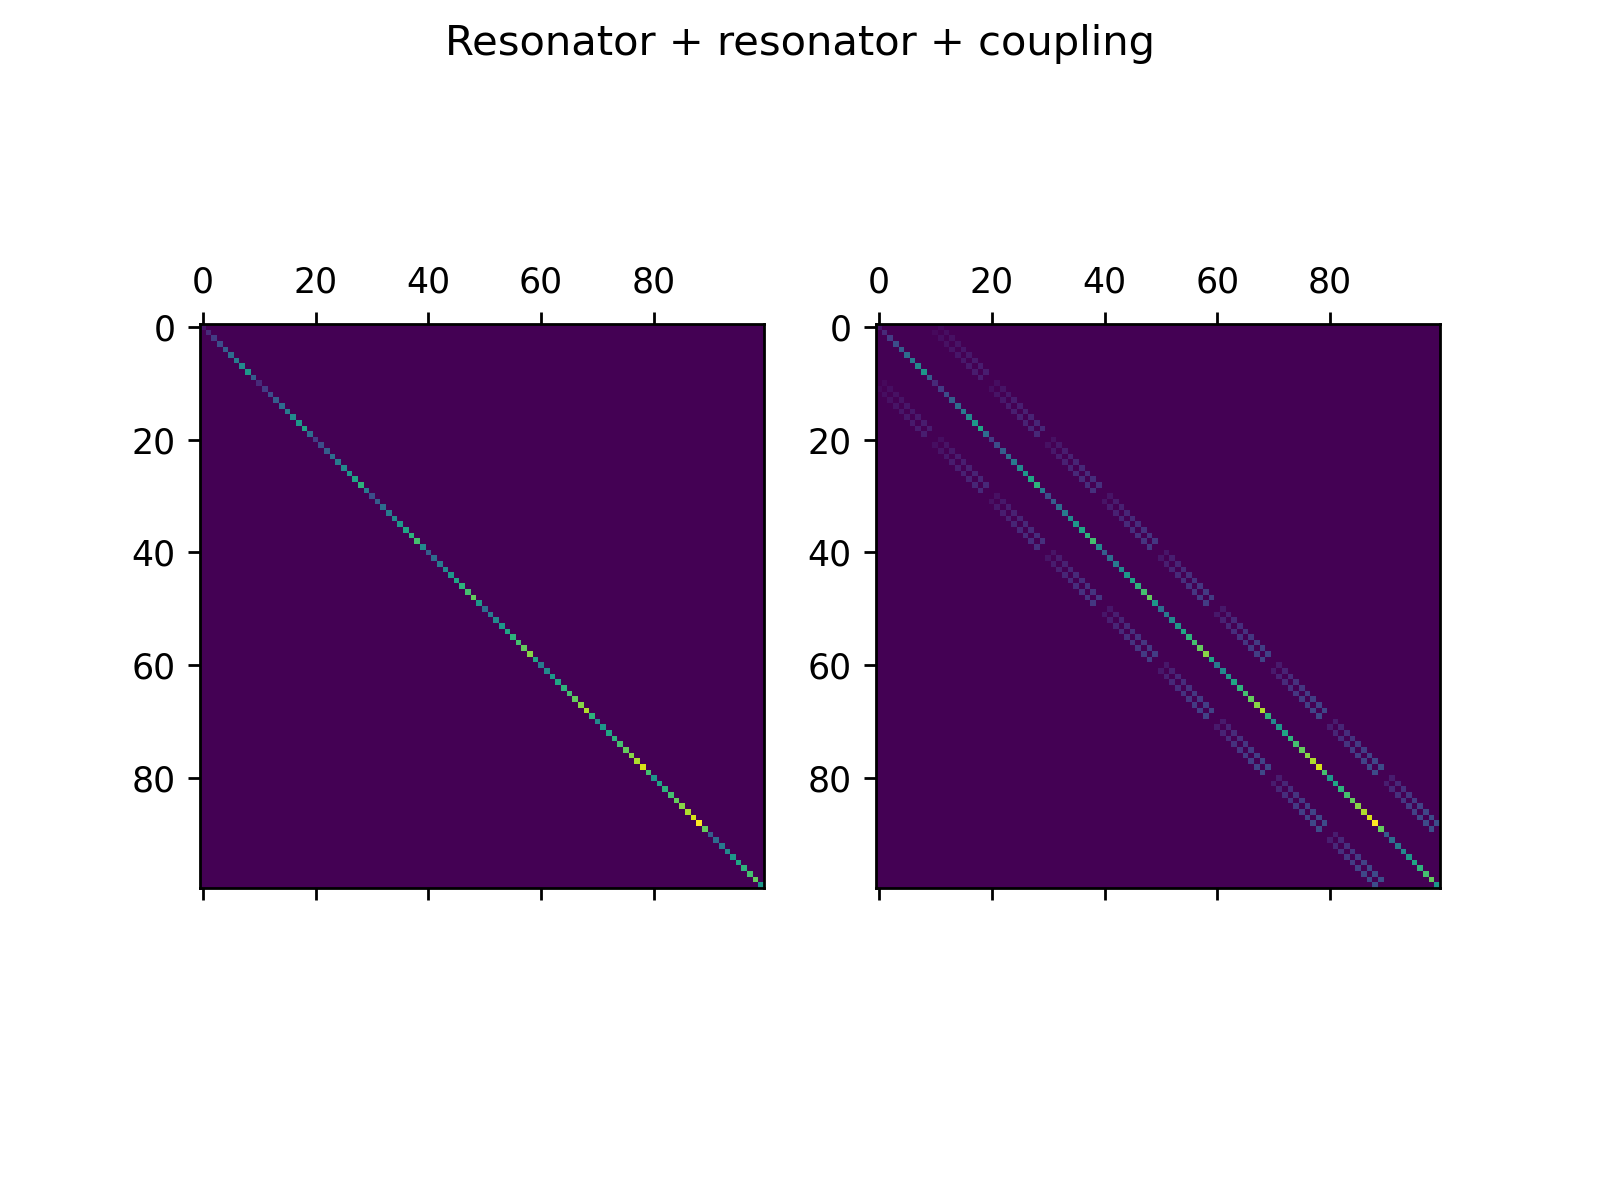

In [178]:
H_0 = H_unc_res.__array__()
H = H_coup_res.__array__()
fig, ax = plt.subplots(ncols=2, dpi=250)
ax[0].matshow(np.abs(H_0))
ax[1].matshow(np.abs(H))
fig.suptitle('Resonator + resonator + coupling')
fig.show()

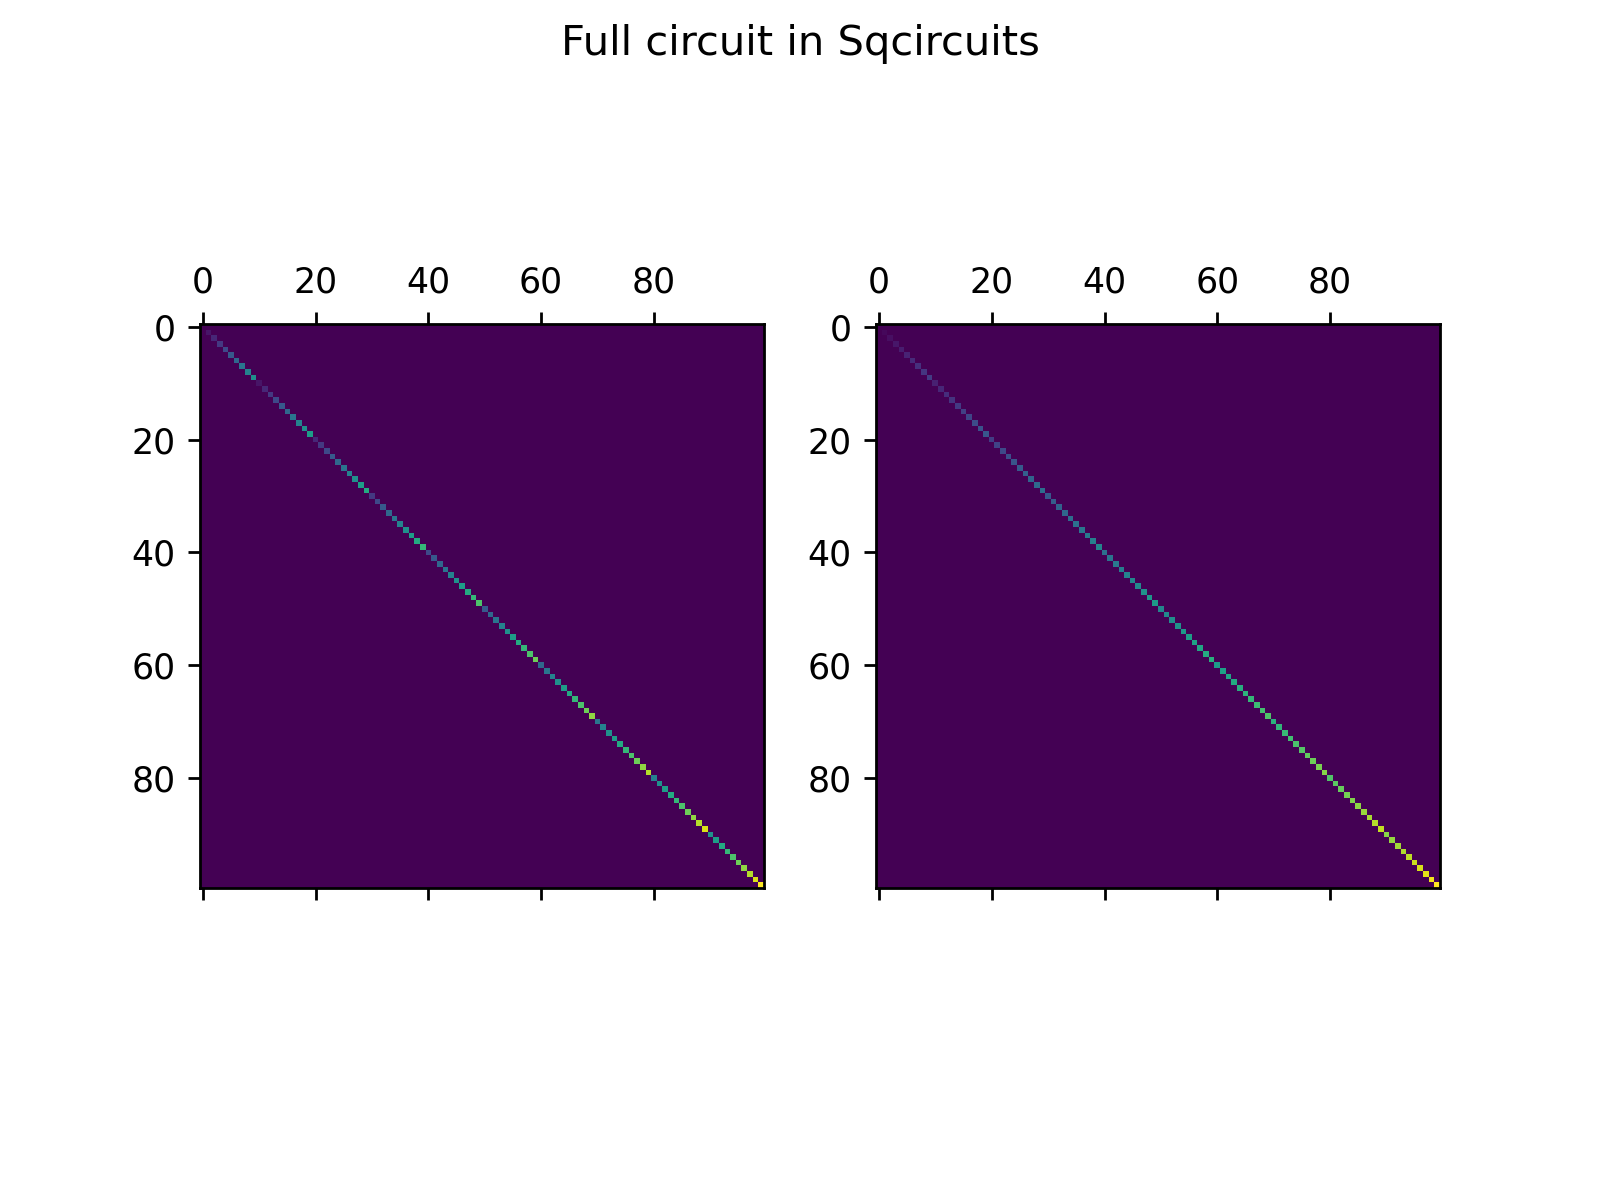

In [177]:
H_0 = uncoupled_res.hamiltonian().__array__()
H = coupled_res.hamiltonian().__array__()
fig, ax = plt.subplots(ncols=2, dpi=250)
ax[0].matshow(np.abs(H_0))
ax[1].matshow(np.abs(H))
fig.suptitle('Full circuit in Sqcircuits')
fig.show()

In [171]:
ψ_0 = sq_ext.diag(H_0, n_eig=len(H_0), real=False, solver='numpy')[1].T
ψ = sq_ext.diag(H, n_eig=len(H), real=False,   solver='numpy')[1].T


In [167]:
H_eff = np.zeros([n_eig,n_eig], dtype='complex')

for i in range(n_eig):
    for j in range(n_eig):
        for k in range(len(ψ)):
            for l in range(len(ψ)):
                H_eff[i,j] += (ψ_0[i].T.conj() @ ψ[k]) * (ψ[k].T.conj() @ H @ ψ[l]) * (ψ[l].T.conj() @ ψ_0[j])

In [168]:
H_eff /= 2 * np.pi * GHz
H_eff -= H_eff[0,0]*np.eye(n_eig)
if np.allclose(np.imag(H_eff),0):
    H_eff = np.real(H_eff)

In [169]:
H_eff

array([[0.000000, -0.000000, 0.000000],
       [-0.000000, 159.154943, 0.000000],
       [0.000000, 0.000000, 729.339574]])

In [124]:
589000*0.005

2945.0

In [79]:

ψ_0 = sq_ext.diag(H_unc_res, n_eig, real=False, solver='numpy')[1]
# ψ_0 = qt.Qobj(H_unc_res).eigenstates(sparse=True, eigvals=n_eig)[1]
# ψ_0 = np.array([ψ.__array__() for ψ in ψ_0])[:,:,0].T

# ψ_0_real = sq_ext.real_eigenvectors(ψ_0)
H_eff = ψ_0.conj().T @ H_coup_res.__array__() @ ψ_0 / GHz /2 /np.pi
# H_eff =np.array( [ [(ψ_0_i.dag() * H_unc_res * ψ_0_j) [0,0] / GHz /2 /np.pi for ψ_0_i in ψ_0] for ψ_0_j in ψ_0])

print(np.round(H_eff, 8))
# print(np.round(np.abs(H_eff), 8))

[[159.94873826+0.j  -0.        +0.j  -0.        +0.j]
 [ -0.        +0.j 319.89747651+0.j   0.79182544+0.j]
 [ -0.        +0.j   0.79182544+0.j 319.89747651+0.j]]


In [89]:
|H_eff_full = sq_ext.H_eff_p1(coupled_res,coupled_res, out=None)
# H_eff_full -= H_eff_full[0,0]*np.eye(n_eig)

H_eff_frc = sq_ext.H_eff_p1_hamil(H_coup_res, H_coup_res, n_eig, out=None)
# H_eff_frc -= H_eff_frc[0,0]*np.eye(n_eig)

print(np.abs(H_eff_full))
print(np.abs(H_eff_frc))
print(np.round(np.abs(H_eff_full-H_eff_frc),4))

[[0.000 0.003 0.002]
 [0.003 999999999999.507 54891.861]
 [0.002 54891.861 1000000009998.506]]
[[525336942860.141 0.004 0.005]
 [0.004 474663058019.876 0.003]
 [0.005 0.003 1474663079600.596]]
[[525336942860.141 0.007 0.004]
 [0.007 525336941979.631 54891.858]
 [0.004 54891.858 474663069602.090]]


In [90]:
ψ_full = np.array([ψ_i.__array__()[:, 0] for ψ_i in res_0._evecs]).T
H_full = res_0.hamiltonian().__array__()

print(np.abs(ψ_full.conj().T @ H_full @ ψ_full))


[[0.000 0.000 0.000]
 [0.000 999999999999.504 0.002]
 [0.000 0.002 1999999999999.011]]


In [91]:
ψ_full = np.array([ψ_i.__array__()[:, 0] for ψ_i in uncoupled_res._evecs]).T
H_full = uncoupled_res.hamiltonian().__array__()

print(np.abs(ψ_full.conj().T @ H_full @ ψ_full))


[[0.000 0.003 0.001]
 [0.003 999999999999.508 210520400652.359]
 [0.001 210520400652.359 999999999999.504]]


In [92]:
# ψ_frc = sq_ext.diag(H_unc_res,n_eig)[1]
ψ_frc = np.linalg.eigh(H_unc_res)[1]
print(np.abs(ψ_frc.conj().T @ H_unc_res.__array__() @ ψ_frc))


[[0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 999999999999.500 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 999999999999.500 ... 0.000 0.000 0.000]
 ...
 [0.000 0.000 0.000 ... 46999999999976.500 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 46999999999976.500 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 47999999999976.000]]


In [93]:
np.abs(uncoupled_res.hamiltonian_op('eig').__array__())

array([[0.000, 0.003, 0.001],
       [0.003, 999999999999.507, 210520400652.359],
       [0.001, 210520400652.359, 999999999999.504]])

In [94]:
H_eff_full = sq_ext.H_eff_p1(res,res, out=None)
# H_eff_full -= H_eff_full[0,0]*np.eye(n_eig)

H_eff_frc = sq_ext.H_eff_p1_hamil(H_res, H_res, n_eig, out=None)
# H_eff_frc -= H_eff_frc[0,0]*np.eye(n_eig)

# print(np.abs(H_eff_full))
# print(np.abs(H_eff_frc))
print(np.round(np.abs(H_eff_full-H_eff_frc),4))


[[0.000 0.010 0.005]
 [0.010 0.000 0.008]
 [0.005 0.008 0.029]]


In [116]:
E = sq_ext.diag(H_coup_res , n_eig, out='GHz')[0]

print( (E-E[0]))
print( coupled_res.efreqs )

print( (E-E[0])[1])
print( coupled_res.efreqs[1] )


[0.000 159.155 318.310]
[0.000 159.155 318.310]
159.15494309182884
159.15494309182222


In [108]:
E = sq_ext.diag(H_unc_res , n_eig, out=None)[0]

print( (E-E[0]))
print( uncoupled_res._efreqs )

print( (E-E[0])[1])
print( uncoupled_res._efreqs[1] )


[0.000 999999999999.494 999999999999.510]
[-0.004 999999999999.507 999999999999.515]
999999999999.4935
999999999999.5068


In [107]:
E = sq_ext.diag(H_res , n_eig, out=None)[0]
print( (E-E[0])[1])
print( res._efreqs[1] )


3316624790353.7407
3316624790353.767


In [106]:
E = sq_ext.diag(H_res_0 , n_eig, out=None)[0]
print( E )
print( res_0._efreqs )


[0.000 999999999999.508 1999999999999.008]
[0.002 999999999999.502 1999999999999.011]


In [3]:
Csh = 15
C   = 15
CJ  = 3
Lq  = 25
Lr  = 10

Cf = C/2 + Csh + CJ
C_f = Cf * 1e-15
C_r = C/2 * 1e-15

In [ ]:
def KIT_resonator(C=15, Lq=25, Lr=10, Δ=0.1):
    l = Lq * (Lq + 4 * Lr) - 4 * Δ ** 2
    resonator_elements = {
        (0, 1): [sq.Capacitor(C / 2, 'fF'), sq.Inductor(l / Lq, 'nH')],
    }
    return sq.Circuit(resonator_elements)


def KIT_fluxonium_no_JJ(C=15, CJ=3, Csh=15, Lq=25, Lr=10, Δ=0.1):
    l = Lq * (Lq + 4 * Lr) - 4 * Δ ** 2
    fluxonium_elements = {
        (0, 1): [sq.Capacitor(C / 2 + Csh + CJ, 'fF'),
                 sq.Inductor(l / (Lq + 4 * Lr), 'nH')],
    }
    return sq.Circuit(fluxonium_elements)

def KIT_qubit_no_JJ(C = 15, CJ = 3, Csh= 15 , Lq = 25, Lr = 10, Δ = 0.1, φ_ext=0.5):

    # Initialize loop(s)
    # loop = sq.Loop(φ_ext)

    # Circuit components
    C_01 = sq.Capacitor(C,       'fF')
    C_02 = sq.Capacitor(C,       'fF')
    C_12 = sq.Capacitor(CJ+Csh,  'fF')
    L_03 = sq.Inductor(Lr,       'nH')
    L_31 = sq.Inductor(Lq/2 - Δ, 'nH')#,  loops=[loop])
    L_23 = sq.Inductor(Lq/2 + Δ, 'nH')#,  loops=[loop])

    elements = {
        (0, 3): [L_03],
        (0, 1): [C_01],
        (0, 2): [C_02],
        (3, 1): [L_31],
        (1, 2): [C_12],
        (2, 3): [L_23],
    }

    # Create and return the circuit
    return sq.Circuit(elements)

def KIT_fluxonium(C = 15, CJ = 3, Csh= 15, Lq = 25, Lr = 10, Δ = 0.1, EJ = 10.0, φ_ext=0.5):
    l = Lq * (Lq + 4 * Lr) - 4 * Δ ** 2
    loop_fluxonium = sq.Loop(φ_ext)
    fluxonium_elements = {
        (0, 1): [sq.Capacitor(C / 2 + Csh + CJ, 'fF'),
                 sq.Inductor(l / (Lq + 4 * Lr), 'nH', loops=[loop_fluxonium]),
                 sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    }
    return sq.Circuit(fluxonium_elements)

def KIT_qubit(C = 15, CJ = 3, Csh= 15 , Lq = 25, Lr = 10, Δ = 0.1, EJ = 10.0, φ_ext=0.5):

    # Initialize loop(s)
    loop = sq.Loop(φ_ext)

    # Circuit components
    C_01 = sq.Capacitor(C,       'fF')
    C_02 = sq.Capacitor(C,       'fF')
    C_12 = sq.Capacitor(CJ+Csh,  'fF')
    L_03 = sq.Inductor(Lr,       'nH')
    L_31 = sq.Inductor(Lq/2 - Δ, 'nH',  loops=[loop])
    L_23 = sq.Inductor(Lq/2 + Δ, 'nH',  loops=[loop])
    JJ_12= sq.Junction(EJ,       'GHz', loops=[loop])

    elements = {
        (0, 3): [L_03],
        (0, 1): [C_01],
        (0, 2): [C_02],
        (3, 1): [L_31],
        (1, 2): [C_12, JJ_12],
        (2, 3): [L_23],
    }

    # Create and return the circuit
    return sq.Circuit(elements)


In [ ]:
n_eig = 4
trunc_num = 20
Δ=1

res     = KIT_resonator          (Δ=Δ)
# flu     = KIT_fluxonium   (Δ=Δ)
# qubit   = KIT_qubit      (Δ=Δ)
flu     = KIT_fluxonium_no_JJ    (Δ=Δ)
qubit   = KIT_qubit_no_JJ        (Δ=Δ)

res_0   = KIT_resonator          (Δ=0)
# flu_0   = KIT_fluxonium    (Δ=0)
# qubit_0 = KIT_qubit       (Δ=0)
flu_0   = KIT_fluxonium_no_JJ    (Δ=0)
qubit_0 = KIT_qubit_no_JJ        (Δ=0)
#
res     .set_trunc_nums([trunc_num])
flu     .set_trunc_nums([trunc_num])
qubit   .set_trunc_nums([1, trunc_num,trunc_num])
# qubit   .set_trunc_nums( [trunc_num,trunc_num])
res_0   .set_trunc_nums([trunc_num])
flu_0   .set_trunc_nums([trunc_num])
qubit_0 .set_trunc_nums([1, trunc_num,trunc_num])
# qubit_0 .set_trunc_nums([trunc_num,trunc_num])

_ = res     .diag(n_eig)
_ = flu     .diag(n_eig)
_ = qubit   .diag(n_eig)
_ = res_0   .diag(n_eig)
_ = flu_0   .diag(n_eig)
_ = qubit_0 .diag(n_eig)


In [ ]:
l = Lq*(Lq+4*Lr) - 4*Δ**2
L_r = l/Lq * 1e-9
L_f = l/(Lq+4*Lr) * 1e-9
L_c = l/Δ * 1e-9

L_r_0 = (Lq+4*Lr) * 1e-9
L_f_0 = Lq * 1e-9


In [ ]:
Q_res = res.charge_op(0)
Φ_res = res.flux_op(0)

Q_res_0 = res_0.charge_op(0)
Φ_res_0 = res_0.flux_op(0)

Q_flu = flu.charge_op(0)
Φ_flu = flu.flux_op(0)

Q_flu_0 = flu_0.charge_op(0)
Φ_flu_0 = flu_0.flux_op(0)


In [ ]:
H_res_0 = 1/2 * Q_res_0**2 / C_r  + 1/2 * Φ_res_0**2 / L_r_0
# H_res = 1/2 * Q_res**2 / C_r  + 1/2 * Φ_res**2 / L_r
H_res = res.hamiltonian()

H_flu_0 = 1/2 * Q_flu_0**2 / C_f + 1/2 * Φ_flu_0**2 / L_f_0
# H_flu = 1/2 * Q_flu**2 / C_f + 1/2 * Φ_flu**2 / L_f
H_flu = flu.hamiltonian()

I_res = qt.identity(H_res.shape[0])
I_flu = qt.identity(H_flu.shape[0])

H_qubit_0 = qt.tensor(H_res_0,I_res) + qt.tensor(I_res,H_flu_0)
H_qubit = qt.tensor(H_res,I_flu) + qt.tensor(I_res,H_flu) + qt.tensor(Φ_res,Φ_flu) * 2 * Δ / l / 1e-9


In [ ]:
Φ, Q = sq_ext.get_node_variables(qubit , 'FC', isolated='True')


In [ ]:
E, ψ = sq_ext.diag(H_qubit , n_eig, out='GHz')
ψ_sq = np.array([ψ_i.__array__()[:, 0] for ψ_i in qubit._evecs])

print( E-E[0])
print( qubit.efreqs )
for i in range(n_eig):
    print(f'Energy error in state{i} = {np.abs((E-E[0])[i]- (qubit.efreqs[i]-qubit.efreqs[0]))}')
    print(f'Wavefunction error in state{i} = {1 - np.abs(ψ[:,i].conj().T @ qubit._evecs[i].__array__())[0]}')



In [ ]:
E, ψ = sq_ext.diag(H_qubit , n_eig, out='GHz')
ψ_sq = np.array([ψ_i.__array__()[:, 0] for ψ_i in qubit._evecs])

print( E-E[0])
print( qubit.efreqs )
for i in range(n_eig):
    print(f'Energy error in state{i} = {np.abs((E-E[0])[i]- (qubit.efreqs[i]-qubit.efreqs[0]))}')
    print(f'Wavefunction error in state{i} = {1 - np.abs(ψ[:,i].conj().T @ qubit._evecs[i].__array__())[0]}')



In [ ]:
E = sq_ext.diag(H_qubit_0 , n_eig, out='GHz')[0]

print( E-E [0])
print( qubit_0.efreqs )

print( (E-E[0])[1])
print( qubit_0.efreqs[1] )


In [ ]:
E = sq_ext.diag(H_res , n_eig, out='GHz')[0]
print(E-E[0] )
print( res.efreqs )

print( (E-E[0])[1])
print( res.efreqs[1] )


In [ ]:
E = sq_ext.diag(H_flu_0, n_eig, out='GHz')[0]
print(E-E[0])
print( flu_0.efreqs )


In [ ]:
E = sq_ext.diag(H_res_0 , n_eig, out='GHz')[0]
print(E-E[0] )
print( res_0.efreqs )




